In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Step 2: Load Dataset
df = pd.read_csv("creditcard.csv")
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.\n")


Dataset loaded with 284807 rows and 31 columns.



In [ ]:

# Step 3: Exploratory Data Analysis (EDA)
# Basic Info
print("Dataset Info:")
print(df.info())

# Check for Missing Values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Check Class Distribution (Imbalance)
print("\nClass Distribution:")
print(df['Class'].value_counts())

# Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

In [ ]:

# Step 4: Handle Missing Values (if any)
if missing_values.sum() > 0:
    print("\nHandling Missing Values...")
    # Assuming numerical columns; replace missing values with median
    df.fillna(df.median(), inplace=True)
    print("Missing values handled.\n")


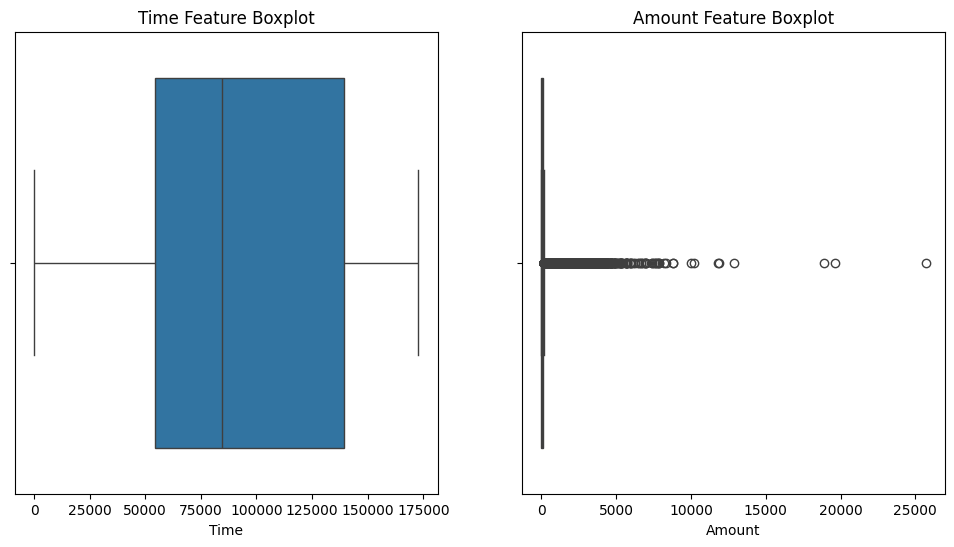


Scaling 'Time' and 'Amount'...

Scaling additional numerical columns:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


In [ ]:

# Step 5: Check and Scale Features
# Check for outliers in 'Time' and 'Amount' columns using boxplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Time'])
plt.title('Time Feature Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Amount'])
plt.title('Amount Feature Boxplot')

plt.show()

# Scale 'Time' and 'Amount'
print("\nScaling 'Time' and 'Amount'...")
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

# Check for other columns needing scaling
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('Class')  # Exclude target column
numerical_cols.remove('Time')  # Already scaled
numerical_cols.remove('Amount')  # Already scaled

if numerical_cols:
    print("\nScaling additional numerical columns:")
    print(numerical_cols)
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [ ]:

# Step 6: Balance Dataset (Subsample for Modeling)
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0].sample(n=len(fraud), random_state=42)
df_balanced = pd.concat([fraud, non_fraud], axis=0).sample(frac=1, random_state=42)  # Shuffle

print(f"\nBalanced Dataset Class Distribution:\n{df_balanced['Class'].value_counts()}")



Balanced Dataset Class Distribution:
Class
0    492
1    492
Name: count, dtype: int64


In [ ]:

# Step 7: Train-Test Split (Subsample)
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:

# Step 8: Define Models and Hyperparameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

In [ ]:
# Step 9: Hyperparameter Tuning and Model Evaluation
best_models = {}

for model_name, model in models.items():
    print(f"\nTuning and validating {model_name}...")
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=20,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        random_state=42
    )
    randomized_search.fit(X_train, y_train)
    best_models[model_name] = randomized_search.best_estimator_
    print(f"Best params for {model_name}: {randomized_search.best_params_}")



Tuning and validating Logistic Regression...
Best params for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

Tuning and validating Random Forest...
Best params for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}

Tuning and validating Gradient Boosting...
Best params for Gradient Boosting: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

Tuning and validating Neural Network...
Best params for Neural Network: {'solver': 'sgd', 'hidden_layer_sizes': (100,), 'activation': 'tanh'}

Tuning and validating KNN...
Best params for KNN: {'weights': 'distance', 'n_neighbors': 10, 'metric': 'euclidean'}



Evaluating Logistic Regression...
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        99
           1       0.97      0.91      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

Logistic Regression AUC: 0.98

Evaluating Random Forest...
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.98      0.92      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

Random Forest AUC: 0.98

Evaluating Gradient Boosting...
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.92   

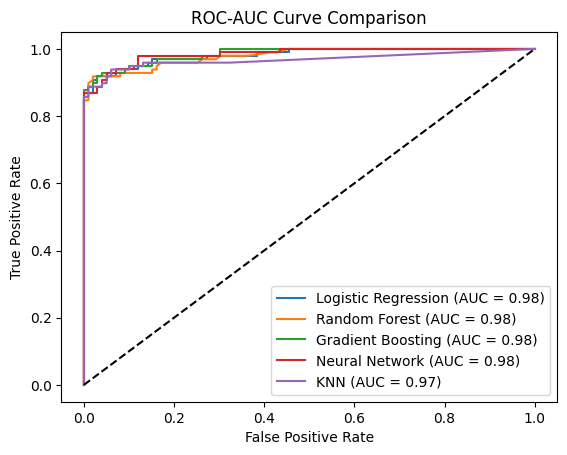


Best Model: Gradient Boosting with AUC = 0.98


In [ ]:

# Step 10: Evaluate Best Models
best_model_name = None
best_auc = 0

for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification)

    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"{model_name} AUC: {roc_auc:.2f}")
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model_name = model_name

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-AUC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"\nBest Model: {best_model_name} with AUC = {best_auc:.2f}")


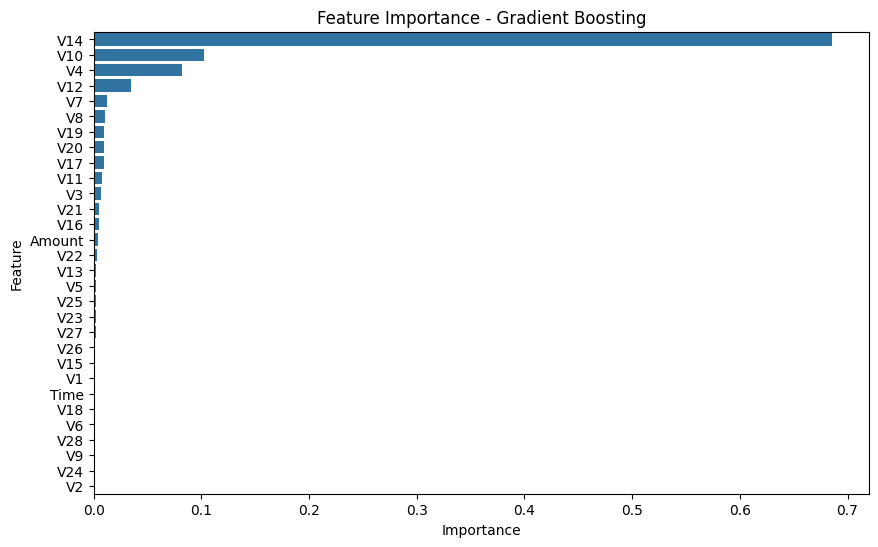

In [ ]:

# Step 11: Feature Importance (Tree-Based Models)
if best_model_name in ["Random Forest", "Gradient Boosting"]:
    best_model = best_models[best_model_name]
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title(f"Feature Importance - {best_model_name}")
        plt.show()


In [ ]:

# Step 12: Train Best Model on Full Dataset
X_full = df.drop('Class', axis=1)
y_full = df['Class']
print(f"\n{X_full.value_counts()}")
print(f"\n{y_full.value_counts()}")



Time       V1         V2         V3         V4         V5         V6         V7          V8          V9         V10        V11        V12        V13        V14        V15        V16        V17        V18        V19        V20        V21         V22         V23        V24        V25        V26        V27        V28        Amount   
 1.439059  -0.610630   0.960421   1.902042   2.386151   1.095245   2.790035   0.473176   -0.130615    0.111637   3.873759   1.357411  -0.709973  -0.257385  -1.631924   1.849876  -0.896102  -0.268455  -0.492538   0.288480   1.784599  -0.504129    0.722605   -0.568763  -1.436136  -0.255523   0.679773  -0.088452  -2.599946  -0.323004    18
           -0.614500   0.953191   1.905538   2.388223   1.114776   2.776277   0.452845   -0.126354    0.112992   3.876573   1.356475  -0.707463  -0.257492  -1.630078   1.849545  -0.898529  -0.267004  -0.491966   0.287851   1.797321  -0.499273    0.719613   -0.572221  -1.436771  -0.257380   0.678144  -0.105662  -2.591053  -0.3

In [ ]:

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_full_resampled, y_full_resampled = smote.fit_resample(X_full, y_full)
print(f"{X_full_resampled.value_counts()}")

print(f"{y_full_resampled.value_counts()}")


Time       V1          V2         V3          V4         V5          V6         V7          V8          V9         V10         V11        V12         V13        V14         V15        V16         V17         V18        V19        V20        V21         V22         V23        V24        V25        V26        V27         V28        Amount   
-0.560285  -6.735448    7.742946  -6.533642    2.345092  -3.478497    4.323496  -15.157238  -31.275101  -0.356389  -4.640228    4.317387  -4.614450   -1.918558  -9.464603   -0.246991  -7.088785   -7.356510   -3.757267   0.063358  -4.530993   37.034714  -12.246126   8.493120  -1.055790   0.504920  -0.225780   3.145358    2.845976  -0.349231    3539
-0.009515  -13.507861   9.990562  -19.902569   6.288841  -12.963357  -0.921664  -25.218289  -9.577521   -8.613065  -20.376666   4.330311  -10.600790  -0.707139  -4.095798   -2.622319  -7.771617   -14.673017  -6.563131  -0.697681   3.647885  -11.920255   4.769040    1.435702   0.420766  -1.415939  -2.004379 

In [ ]:

# Retrain best model on full dataset
print(f"\nBest Model: {best_model_name}")

final_model = best_models[best_model_name]
final_model.fit(X_full_resampled, y_full_resampled)

print("\nFinal model trained on the full dataset.")



Best Model: Gradient Boosting

Final model trained on the full dataset.


In [ ]:

# Step 13: Save Final Model
import joblib
joblib.dump(final_model, f"{best_model_name}_final_model.pkl")
print(f"Final model saved as '{best_model_name}_final_model.pkl'.")